In [1]:
%pip install tensorflow_addons

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
sys.path.append("/content/drive/MyDrive/HM/")

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, Dense, Dropout, BatchNormalization, Concatenate
import numpy as np
import pandas as pd
import gc

In [5]:
import tensorflow_addons as tfa

In [6]:
from src.data import DataHelper
from src.data.metrics import map_at_k

In [7]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [8]:
from pathlib import Path
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [9]:
# * uncomment this when predicting testset to avoid GPU memory error
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [11]:
RANK_EMBEDDING_DIM = 64
BATCH_SIZE = 2**12
NEPOCH = 20

In [12]:
TRAIN_WEEK_NUM = 4
WEEK_NUM = TRAIN_WEEK_NUM + 2

VERSION_NAME = "LargeRecall"

In [13]:
data_dir = Path("/content/drive/MyDrive/HM/data/")
model_dir = Path("/content/drive/MyDrive/HM/models/")

In [14]:
dh = DataHelper(data_dir)
data = dh.load_data(name="encoded_full")

In [15]:
inter = data['inter']
inter = inter.loc[(inter.t_dat <= "2020-08-19")]

## Calculate & Load Embeddings

In [16]:
# article description - TFIDF - SVD
if not os.path.exists(data_dir/'external/tfidf_item_embd.npy'):
    articles = pd.read_csv(data_dir/'raw/articles.csv')

    corpus = articles[[col for col in articles.columns if 'name' in col] + ['detail_desc']].T.apply(lambda x: ' '.join(map(str,x))).T

    vectorizer = TfidfVectorizer(min_df=3)
    X = vectorizer.fit_transform(corpus)
    svd = TruncatedSVD(n_components=256, random_state=0)
    tfidf_item = svd.fit_transform(X)
    tfidf_item = np.concatenate([np.ones((1,256)), tfidf_item], axis=0)
    tfidf_item.dump(data_dir/'external/tfidf_item_embd.npy')
else:
    tfidf_item = np.load(data_dir/'external/tfidf_item_embd.npy', allow_pickle=True)

In [17]:
# article_id - customer_id TFIDF + SVD
if not os.path.exists(data_dir/'external/tfidf_item_embd2.npy'):
    corpus = inter.groupby('article_id').customer_id.apply(lambda x: ' '.join(map(str, x)))
    article_ids = np.array(list(corpus.index))

    vectorizer = TfidfVectorizer(min_df=3)
    X = vectorizer.fit_transform(corpus)
    svd = TruncatedSVD(n_components=128, random_state=0)
    X_svd = svd.fit_transform(X)

    item_num = data['item']['article_id'].nunique()
    tfidf_item2 = np.ones((item_num+1, 128)) / 128
    for i,iid in enumerate(article_ids):
        tfidf_item2[iid,:] = X_svd[i,:]

    tfidf_item2.dump(data_dir/'external/tfidf_item_embd2.npy')
else:
    tfidf_item2 = np.load(data_dir/'external/tfidf_item_embd2.npy', allow_pickle=True)

In [18]:
# customer_id - product_code TFIDF + SVD
if not os.path.exists(data_dir/'external/tfidf_user_embd.npy'):
    inter = inter.merge(data['item'][['article_id','product_code']], on=['article_id'], how='left')
    corpus = inter.groupby('customer_id').product_code.apply(lambda x: ' '.join(map(str, x)))
    customer_ids = np.array(list(corpus.index))

    vectorizer = TfidfVectorizer(min_df=3)
    X = vectorizer.fit_transform(corpus)
    svd = TruncatedSVD(n_components=128, random_state=0)
    X_svd = svd.fit_transform(X)

    user_num = data['user']['customer_id'].nunique()
    tfidf_user = np.ones((user_num+1, 128)) / 128
    for i,uid in enumerate(customer_ids):
        tfidf_user[uid,:] = X_svd[i,:]

    tfidf_user.dump(data_dir/'external/tfidf_user_embd.npy')
else:
    tfidf_user = np.load(data_dir/'external/tfidf_user_embd.npy', allow_pickle=True)

In [19]:
# * Load pre-trained embeddings
w2v_user_embd = np.load(data_dir/'external'/'w2v_user_embd.npy', allow_pickle=True)
w2v_item_embd = np.load(data_dir/'external'/'w2v_item_embd.npy', allow_pickle=True)
w2v_product_embd = np.load(data_dir/'external'/'w2v_product_embd.npy', allow_pickle=True)
image_item_embd = np.load(data_dir/'external'/'image_embd.npy', allow_pickle=True)
w2v_sg_user_embd = np.load(data_dir/'external'/'w2v_skipgram_user_embd.npy', allow_pickle=True)
w2v_sg_item_embd = np.load(data_dir/'external'/'w2v_skipgram_item_embd.npy', allow_pickle=True)
w2v_sg_product_embd = np.load(data_dir/'external'/'w2v_skipgram_product_embd.npy', allow_pickle=True)

## Load Candidates & Prepare Data

In [20]:
candidates = {}
labels = {}
for i in tqdm(range(1, WEEK_NUM)):
    candidates[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")
    candidates[i] = candidates[i][candidates[i]['rank']<=50]
    labels[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_label.pqt")

100%|██████████| 5/5 [00:58<00:00, 11.67s/it]


In [21]:
feats = [
    x
    for x in candidates[1].columns
    if x
    not in [
        "label",
        "sales_channel_id",
        "t_dat",
        "week",
        "wv_similarity"
    ]
]

ids = ["customer_id", "article_id", "product_code"]
dense_feats = [x for x in feats if x not in ids]

In [22]:
for f in tqdm(dense_feats):
    for i in range(1,WEEK_NUM):
        if f in candidates[i].columns:
            candidates[i][f] = candidates[i][f].astype('float16')

100%|██████████| 99/99 [00:55<00:00,  1.79it/s]


In [23]:
full_data = pd.concat([candidates[i] for i in range(1,WEEK_NUM)], ignore_index=True)

# =============================================
inter = data['inter']
inter = inter[inter['t_dat']<'2020-08-19'] # * start date of the last valid week
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7
inter = inter.merge(data['item'][["article_id", "product_code"]], on="article_id", how="left")


tmp = inter.groupby('article_id').week.mean()
full_data['article_time_mean'] = full_data['article_id'].map(tmp)

tmp = inter.groupby('customer_id').week.nth(-1)
full_data['customer_id_last_time'] = full_data['customer_id'].map(tmp)

tmp = inter.groupby('customer_id').week.nth(0)
full_data['customer_id_first_time'] = full_data['customer_id'].map(tmp)

tmp = inter.groupby('customer_id').week.mean()
full_data['customer_id_time_mean'] = full_data['customer_id'].map(tmp)

full_data['customer_id_gap'] = full_data['customer_id_first_time'] - full_data['customer_id_last_time']

tmp = inter.groupby('customer_id').size()
full_data['customer_daily_bought'] = full_data['customer_id'].map(tmp) / full_data['customer_id_gap']

tmp = inter.groupby('customer_id').price.median()
full_data['customer_id_price_median'] = full_data['customer_id'].map(tmp)

full_data['customer_article_price_gap'] = full_data['customer_id_price_median'] - full_data['price']

del tmp
gc.collect()

from itertools import chain
def dict_union(L):
    return dict(chain.from_iterable(d.items() for d in L))

dur = [52]
for col in tqdm(["article_id","product_code"]):
    full_data[f'{col}_id_week'] = full_data[col].astype('str') + '_' + full_data['week'].astype('str')

    for j in dur:
        dict_list = []
        for i in range(5):
            tmp = inter[(inter['week']>=(1+i+1)) & (inter['week']<(1+i+2+j))]
            
            tmp['week'] = i+1
            tmp = tmp.groupby(['week', col]).size().reset_index()
            tmp.columns = ['week', col, 'count_sales']

            tmp[f'{col}_id_week'] = tmp[col].astype('str') + '_'+tmp['week'].astype('str')

            dict_list.append( dict(zip(tmp[f'{col}_id_week'], tmp['count_sales'])) )
            del tmp

        dict_all = dict_union(dict_list)
        full_data[f'{col}_week_shift{j}'] = full_data[f'{col}_id_week'].map(dict_all)

        del dict_all
    gc.collect()


full_data['article_id_week_1/52'] = full_data['i_sale'] / full_data[f'article_id_week_shift52']
full_data['product_code_week_1/52'] = full_data['i_sale'] / full_data[f'product_code_week_shift52']

# =============================================
extra_feats = [
    'article_time_mean', 
    'customer_id_last_time', 
    'customer_id_first_time', 
    'customer_id_time_mean',
    'customer_id_gap',
    'customer_id_price_median',
    'customer_daily_bought',
    'customer_article_price_gap'
] + [f'{col}_week_shift{j}' for col in ["article_id","product_code"] for j in dur] +\
['article_id_week_1/52', 'product_code_week_1/52']
feats += extra_feats
dense_feats += extra_feats

for f in extra_feats:
    full_data[f] = full_data[f].astype('float16')

# =============================================

full_data = full_data[feats+['week','label']]
# full_data, _ = reduce_mem_usage(full_data)

100%|██████████| 2/2 [01:07<00:00, 33.91s/it]


In [24]:
gc.collect()
train = full_data[full_data['week']>1]
valid = full_data[full_data['week']==1]

In [25]:
del candidates
gc.collect()

50

In [26]:
feat_dim = {}
for feat in ids:
    if feat in data['user'].columns:
        feat_dim[feat] = int(data['user'][feat].max()) + 1
    elif feat in data['item'].columns:
        feat_dim[feat] = int(data['item'][feat].max()) + 1
    else:
        feat_dim[feat] = int(full_data[feat].max()) + 1

In [27]:
del full_data
gc.collect()

100

In [28]:
X_train1 = train[['customer_id', 'article_id', 'product_code']].values.astype('int32')
X_train2 = np.zeros((X_train1.shape[0], len(dense_feats)), dtype='float32')
for i,f in tqdm(enumerate(dense_feats)):
    X_train2[:, i] = np.nan_to_num(train[f].values).astype('float32')
    del train[f]
y_train = train['label'].values

111it [00:58,  1.91it/s]


In [29]:
X_test1 = valid[['customer_id', 'article_id', 'product_code']].values.astype('int32')
X_test2 = np.zeros((X_test1.shape[0], len(dense_feats)), dtype='float32')
for i,f in tqdm(enumerate(dense_feats)):
    X_test2[:, i] = np.nan_to_num(valid[f].values).astype('float32')
    del valid[f]
y_test = valid['label'].values

111it [00:12,  9.04it/s]


## Train Model

In [30]:
customer_embd_layer_1 = Embedding(
    feat_dim["customer_id"], 128, weights=[w2v_sg_user_embd], trainable=False
)
customer_embd_layer_2 = Embedding(
    feat_dim["customer_id"], 128, weights=[w2v_user_embd], trainable=False
)
customer_embd_layer_3 = Embedding(
    feat_dim["customer_id"], 128, weights=[tfidf_user], trainable=False
)

In [31]:
article_embd_layer_1 = Embedding(
    feat_dim["article_id"], 128, weights=[w2v_sg_item_embd], trainable=False
)

article_embd_layer_2 = Embedding(
    feat_dim["article_id"], 128, weights=[w2v_item_embd], trainable=False
)

article_embd_layer_3 = Embedding(
    feat_dim["article_id"], 256, weights=[tfidf_item], trainable=False
)

article_embd_layer_4 = Embedding(
    feat_dim["article_id"], 128, weights=[tfidf_item2], trainable=False
)

article_embd_layer_5 = Embedding(
    feat_dim["article_id"], 512, weights=[image_item_embd], trainable=False
)

In [32]:
product_embd_layer_1 = Embedding(
    feat_dim["product_code"], 128, weights=[w2v_sg_product_embd], trainable=False
)
product_embd_layer_2 = Embedding(
    feat_dim["product_code"], 128, weights=[w2v_product_embd], trainable=False
)

In [33]:
inputs1 = Input(shape=X_train1.shape[1:], dtype=tf.int64)
inputs2 = Input(shape=X_train2.shape[1:], dtype=tf.float32)
input1 = tf.cast(inputs1, dtype=tf.int64)

x_c_id1 = customer_embd_layer_1(input1[:,0])
x_c_id2 = customer_embd_layer_2(input1[:,0])
x_c_id3 = customer_embd_layer_3(input1[:,0])

x_a_id1 = article_embd_layer_1(input1[:,1])
x_a_id2 = article_embd_layer_2(input1[:,1])
x_a_id3 = article_embd_layer_3(input1[:,1])
x_a_id3 = Dense(128)(x_a_id3)
x_a_id4 = article_embd_layer_4(input1[:,1])
x_a_id5 = article_embd_layer_5(input1[:,1])
x_a_id5 = Dense(128)(x_a_id5)

x_p_id1 = product_embd_layer_1(input1[:,2])
x_p_id2 = product_embd_layer_2(input1[:,2])


x_id = Concatenate(axis=-1)([
    x_c_id1, x_c_id2,
    x_a_id1, x_a_id2, x_a_id3, x_a_id4, x_a_id5,
    x_p_id1, x_p_id2,
])

x0 = Concatenate(axis=-1)([x_id, BatchNormalization()(inputs2)])

x = Dropout(0.3)(x0)
x = Dense(512, activation='swish')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='swish')(x)

x = Concatenate(axis=-1)([x, x0])
x = Dropout(0.3)(x)

output = Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[inputs1, inputs2], outputs=[output])
# model.summary()
    
model.compile(
    tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4),
    loss = 'binary_crossentropy',
    metrics=['AUC']
)

In [34]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, mode='max')
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_dir/'large_nn.h5',
    save_weights_only=True,
    monitor='val_auc',
    mode='max',
    save_best_only=True)

history = model.fit(
    [X_train1, X_train2], y_train.astype(int), 
    shuffle=True,
    batch_size=2048,
    validation_data=([X_test1, X_test2], y_test.astype(int)),
    epochs=30,
    callbacks=[checkpoint, early_stop]
)

In [35]:
model.load_weights(model_dir/'large_nn.h5')

probs = model.predict([X_test1, X_test2], batch_size=4096)
label = data['inter'][data['inter']['t_dat']>='2020-09-16']
label = label.groupby('customer_id')['article_id'].apply(list).reset_index()

valid['prob'] = probs
pred = valid.sort_values(by='prob',ascending=False).reset_index(drop=True)
pred = pred.groupby('customer_id')['article_id'].apply(list).reset_index()
pred.columns = ['customer_id','prediction']

label = label.merge(pred, on='customer_id', how='left')

map_at_k(label['article_id'], label['prediction'], k=12)

In [ ]:
valid = valid[['customer_id','article_id','prob']]
valid.to_parquet(data_dir/'external'/'large_nn_valid.pqt')

## Test

In [36]:
model.load_weights(model_dir/'large_nn.h5')

In [37]:
class TQDMPredictCallback(tf.keras.callbacks.Callback):
    def __init__(self, custom_tqdm_instance=None, tqdm_cls=tqdm, **tqdm_params):
        super().__init__()
        self.tqdm_cls = tqdm_cls
        self.tqdm_progress = None
        self.prev_predict_batch = None
        self.custom_tqdm_instance = custom_tqdm_instance
        self.tqdm_params = tqdm_params

    def on_predict_batch_begin(self, batch, logs=None):
        pass

    def on_predict_batch_end(self, batch, logs=None):
        self.tqdm_progress.update(batch - self.prev_predict_batch)
        self.prev_predict_batch = batch

    def on_predict_begin(self, logs=None):
        self.prev_predict_batch = 0
        if self.custom_tqdm_instance:
            self.tqdm_progress = self.custom_tqdm_instance
            return

        total = self.params.get('steps')
        if total:
            total -= 1

        self.tqdm_progress = self.tqdm_cls(total=total, **self.tqdm_params)

    def on_predict_end(self, logs=None):
        if self.tqdm_progress and not self.custom_tqdm_instance:
            self.tqdm_progress.close()

In [38]:
del train, valid, X_train1, X_train2, X_test1, X_test2
gc.collect()

685

In [39]:
TEST_BATCH_NUM = 10

In [40]:
files = os.listdir(data_dir/"processed"/VERSION_NAME)
for batch in range(TEST_BATCH_NUM):
    chunk_files = [f for f in files if f.startswith(f"week0_candidate_{batch}")]
    for chunk,chunk_file in enumerate(sorted(chunk_files)):
        print(chunk_file)
        test_candidate = pd.read_parquet(data_dir/"processed"/VERSION_NAME/chunk_file)
        test_candidate = test_candidate[test_candidate['rank']<=50].reset_index(drop=True)
        # * ============================================================================================

        tmp = inter.groupby('article_id').week.mean()
        test_candidate['article_time_mean'] = test_candidate['article_id'].map(tmp)

        tmp = inter.groupby('customer_id').week.nth(-1)
        test_candidate['customer_id_last_time'] = test_candidate['customer_id'].map(tmp)

        tmp = inter.groupby('customer_id').week.nth(0)
        test_candidate['customer_id_first_time'] = test_candidate['customer_id'].map(tmp)

        tmp = inter.groupby('customer_id').week.mean()
        test_candidate['customer_id_time_mean'] = test_candidate['customer_id'].map(tmp)

        test_candidate['customer_id_gap'] = test_candidate['customer_id_first_time'] - test_candidate['customer_id_last_time']

        tmp = inter.groupby('customer_id').size()
        test_candidate['customer_daily_bought'] = test_candidate['customer_id'].map(tmp) / test_candidate['customer_id_gap']

        tmp = inter.groupby('customer_id').price.median()
        test_candidate['customer_id_price_median'] = test_candidate['customer_id'].map(tmp)

        test_candidate['customer_article_price_gap'] = test_candidate['customer_id_price_median'] - test_candidate['price']

        del tmp
        gc.collect()

        from itertools import chain
        def dict_union(L):
            return dict(chain.from_iterable(d.items() for d in L))

        dur = [52]
        for col in tqdm(["article_id","product_code"]):
            test_candidate[f'{col}_id_week'] = test_candidate[col].astype('str') + '_' + test_candidate['week'].astype('str')

            for j in dur:
                dict_list = []
                for i in range(5):
                    tmp = inter[(inter['week']>=(1+i+1)) & (inter['week']<(1+i+2+j))]
                    
                    tmp['week'] = i+1
                    tmp = tmp.groupby(['week', col]).size().reset_index()
                    tmp.columns = ['week', col, 'count_sales']

                    tmp[f'{col}_id_week'] = tmp[col].astype('str') + '_'+tmp['week'].astype('str')

                    dict_list.append( dict(zip(tmp[f'{col}_id_week'], tmp['count_sales'])) )
                    del tmp

                dict_all = dict_union(dict_list)
                test_candidate[f'{col}_week_shift{j}'] = test_candidate[f'{col}_id_week'].map(dict_all)

                del dict_all
            gc.collect()

        test_candidate['article_id_week_1/52'] = test_candidate['i_sale'] / test_candidate[f'article_id_week_shift52']
        test_candidate['product_code_week_1/52'] = test_candidate['i_sale'] / test_candidate[f'product_code_week_shift52']

        # * =================================================================================================================
        for f in tqdm(dense_feats):
            test_candidate[f] = test_candidate[f].astype('float16')
        
        test1 = test_candidate[['customer_id', 'article_id', 'product_code']].values.astype('int32')
        test2 = np.zeros((test1.shape[0], len(dense_feats)), dtype='float32')
        for i,f in tqdm(enumerate(dense_feats)):
            test2[:, i] = np.nan_to_num(test_candidate[f].values).astype('float32')
            del test_candidate[f]
        gc.collect()

        probs = model.predict([test1, test2], batch_size=2048, callbacks=[TQDMPredictCallback()])
        test_candidate["prob"] = probs
        pred_nn = test_candidate[['customer_id','article_id','prob']]
        # pred_nn.rename(columns={'article_id':'prediction'}, inplace=True)
        pred_nn['customer_id'] = pred_nn['customer_id'].astype(int)
        pred_nn.to_parquet(data_dir/"interim"/VERSION_NAME/f"large_nn_test_{batch}_{chunk}.pqt")

week0_candidate_0_0.pqt


100%|██████████| 111/111 [00:20<00:00,  5.38it/s]
111it [00:23,  4.66it/s]
100%|██████████| 3053/3053 [00:55<00:00, 55.20it/s]


week0_candidate_0_1.pqt


100%|██████████| 111/111 [00:47<00:00,  2.32it/s]
111it [00:48,  2.29it/s]
100%|██████████| 6020/6020 [01:47<00:00, 55.97it/s]


week0_candidate_0_2.pqt


100%|██████████| 111/111 [00:00<00:00, 2606.08it/s]
111it [00:00, 2739.29it/s]
0it [00:00, ?it/s]


week0_candidate_1_0.pqt


100%|██████████| 111/111 [00:22<00:00,  4.88it/s]
111it [00:26,  4.13it/s]
100%|██████████| 3389/3389 [00:59<00:00, 56.56it/s]


week0_candidate_1_1.pqt


100%|██████████| 111/111 [00:43<00:00,  2.58it/s]
111it [00:46,  2.41it/s]
100%|██████████| 5680/5680 [01:42<00:00, 55.58it/s]


week0_candidate_1_2.pqt


100%|██████████| 111/111 [00:00<00:00, 2499.02it/s]
111it [00:00, 2268.89it/s]
0it [00:00, ?it/s]


week0_candidate_2_0.pqt


100%|██████████| 111/111 [00:25<00:00,  4.37it/s]
111it [00:29,  3.77it/s]
100%|██████████| 3729/3729 [01:06<00:00, 56.49it/s]


week0_candidate_2_1.pqt


100%|██████████| 111/111 [00:40<00:00,  2.76it/s]
111it [00:43,  2.57it/s]
100%|██████████| 5345/5345 [01:34<00:00, 56.76it/s]


week0_candidate_3_0.pqt


100%|██████████| 111/111 [00:29<00:00,  3.74it/s]
111it [00:32,  3.39it/s]
100%|██████████| 4065/4065 [01:13<00:00, 55.31it/s]


week0_candidate_3_1.pqt


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]
111it [00:40,  2.72it/s]
100%|██████████| 5008/5008 [01:31<00:00, 54.76it/s]


week0_candidate_3_2.pqt


100%|██████████| 111/111 [00:00<00:00, 2638.85it/s]
111it [00:00, 2797.82it/s]
0it [00:00, ?it/s]


week0_candidate_4_0.pqt


100%|██████████| 111/111 [00:32<00:00,  3.42it/s]
111it [00:35,  3.16it/s]
100%|██████████| 4403/4403 [01:18<00:00, 55.74it/s]


week0_candidate_4_1.pqt


100%|██████████| 111/111 [00:34<00:00,  3.26it/s]
111it [00:37,  2.93it/s]
100%|██████████| 4673/4673 [01:24<00:00, 55.50it/s]


week0_candidate_5_0.pqt


100%|██████████| 111/111 [00:35<00:00,  3.11it/s]
111it [00:38,  2.90it/s]
100%|██████████| 4739/4739 [01:24<00:00, 55.84it/s]


week0_candidate_5_1.pqt


100%|██████████| 111/111 [00:31<00:00,  3.47it/s]
111it [00:35,  3.17it/s]
100%|██████████| 4334/4334 [01:17<00:00, 55.77it/s]


week0_candidate_6_0.pqt


100%|██████████| 111/111 [00:37<00:00,  2.93it/s]
111it [00:41,  2.69it/s]
100%|██████████| 5078/5078 [01:30<00:00, 55.86it/s]


week0_candidate_6_1.pqt


100%|██████████| 111/111 [00:28<00:00,  3.95it/s]
111it [00:32,  3.44it/s]
100%|██████████| 3998/3998 [01:11<00:00, 55.78it/s]


week0_candidate_7_0.pqt


100%|██████████| 111/111 [00:41<00:00,  2.71it/s]
111it [00:43,  2.53it/s]
100%|██████████| 5415/5415 [01:38<00:00, 54.95it/s]


week0_candidate_7_1.pqt


100%|██████████| 111/111 [00:24<00:00,  4.47it/s]
111it [00:29,  3.76it/s]
100%|██████████| 3660/3660 [01:04<00:00, 56.36it/s]


week0_candidate_7_2.pqt


100%|██████████| 111/111 [00:00<00:00, 2286.79it/s]
111it [00:00, 2708.68it/s]
0it [00:00, ?it/s]


week0_candidate_8_0.pqt


100%|██████████| 111/111 [00:45<00:00,  2.44it/s]
111it [00:46,  2.38it/s]
100%|██████████| 5752/5752 [01:43<00:00, 55.38it/s]


week0_candidate_8_1.pqt


100%|██████████| 111/111 [00:21<00:00,  5.17it/s]
111it [00:26,  4.25it/s]
100%|██████████| 3325/3325 [01:00<00:00, 55.31it/s]


week0_candidate_8_2.pqt


100%|██████████| 111/111 [00:00<00:00, 2374.84it/s]
111it [00:00, 2742.23it/s]
0it [00:00, ?it/s]


week0_candidate_9_0.pqt


100%|██████████| 111/111 [00:46<00:00,  2.38it/s]
111it [00:47,  2.35it/s]
100%|██████████| 5766/5766 [01:50<00:00, 51.99it/s]


week0_candidate_9_1.pqt


100%|██████████| 111/111 [00:17<00:00,  6.30it/s]
111it [00:22,  4.93it/s]
100%|██████████| 2753/2753 [00:50<00:00, 54.90it/s]


---

In [43]:
files = os.listdir(data_dir/"interim"/VERSION_NAME)
chunk_files = [f for f in files if f.startswith("large_nn_test_")]

In [45]:
test_l = []
for f in tqdm(chunk_files):
    tmp_df = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f)
    test_l.append(tmp_df)

100%|██████████| 25/25 [00:16<00:00,  1.52it/s]


In [46]:
test_pred = pd.concat(test_l, ignore_index=True)

In [47]:
test_pred['customer_id'].nunique()

1371980

In [48]:
test_pred.to_parquet(data_dir/"processed"/"large_nn_test.pqt")

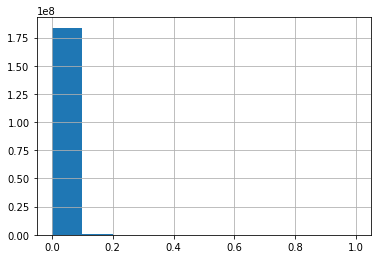

In [49]:
test_pred['prob'].hist()